In [1]:
import cv2 as cv
import numpy as np
from os import listdir
from matplotlib import image
import scipy.spatial.distance as dist
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt
import pandas as pd

loaded_images_car = list()
loaded_images_ship = list()

cp=0
path_1='DB2C/obj_car'
for filename in listdir(path_1):
    cp+=1
    if cp>90:
        break
    img_data_1 = image.imread(path_1+'/' + filename)
    loaded_images_car.append(img_data_1)

path_2='DB2C/obj_ship'
for filename in listdir(path_2):
    img_data_2 = image.imread(path_2+'/' + filename)
    loaded_images_ship.append(img_data_2)

In [2]:
def hsvHistogramFeatures(image):
    rows,cols,dd = image.shape
    image = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    
    h = image[...,0]
    s = image[...,1]
    v = image[...,2]
    
    numberOfLevelsForH = 8
    numberOfLevelsForS = 2
    numberOfLevelsForV = 2
    
    maxValueForH = np.max(h)
    maxValueForS = np.max(s)
    maxValueForV = np.max(v)
    
    hsvColorHisto = np.zeros((8,2,2))
    
    quantizedValueForH = (h*numberOfLevelsForH/maxValueForH)
    quantizedValueForS = (s*numberOfLevelsForS/maxValueForS)
    quantizedValueForV = (v*numberOfLevelsForV/maxValueForV)
    
    index = np.zeros((rows*cols,3))
    index[:,0] = quantizedValueForH.flatten()
    index[:,1] = quantizedValueForS.flatten()
    index[:,2] = quantizedValueForV.flatten()
    
    for i in range(len(index[:,0])):
        if(index[i,0]==0 or index[i,1]==0 or index[i,2]==0):
            continue
        hsvColorHisto[int(index[i,0]),int(index[i,1]),int(index[i,2])] +=1
    hsvColorHisto = hsvColorHisto.flatten()
    hsvColorHisto /= np.sum(hsvColorHisto)
    return hsvColorHisto.reshape(-1)


def color_Moments(img):
    img = np.reshape(img,(-1,3))
    image_mean = np.mean(img,axis=0)
    image_std = np.std(img,0)
    colorFeatures = [image_mean[0],image_std[0],image_mean[1],image_std[1],image_mean[2],image_std[2]]
    return colorFeatures

def  textureFeatures(img):
    features_texture = np.zeros(4)
    im = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    glcm = greycomatrix(im, [1,2,3], [0],levels=256, symmetric=True, normed=True)
    features_texture[0] = np.mean(greycoprops(glcm, 'correlation'))
    features_texture[1] = np.mean(greycoprops(glcm, 'contrast'))
    features_texture[2] = np.mean(greycoprops(glcm, 'homogeneity'))
    features_texture[3] = np.mean(greycoprops(glcm, 'energy'))
    
    return features_texture

def shapeFeatures(img):
    im = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    shapeFeat = cv.HuMoments(cv.moments(im)).flatten()
    shapeFeat /= np.mean(shapeFeat)
    return shapeFeat

def getFeatures(img, fsize):
    features = np.zeros(fsize)
    if fsize == 6:
        features[0:fsize] = color_Moments(img)
    elif fsize == 38:
        features[0:6] = color_Moments(img)
        features[6:fsize] = hsvHistogramFeatures(img)
    elif fsize == 42:
        features[0:6] = color_Moments(img)
        features[6:38] = hsvHistogramFeatures(img)
        features[38:fsize] = textureFeatures(img)
    elif fsize == 49:
        features[0:6] = color_Moments(img)
        features[6:38] = hsvHistogramFeatures(img)
        features[38:42] = textureFeatures(img)
        features[42:fsize] = shapeFeatures(img)
    else:
        print("error: no such size")
        exit(0)
    return features

def Indexation(fsize):
    leng_car = len(loaded_images_car)
    features_car = np.zeros((leng_car,fsize+1))
    for i in range(leng_car):
        features_car[i][0:fsize] = getFeatures(loaded_images_car[i],fsize)
        features_car[i][fsize] = 0
        
    leng_ship = len(loaded_images_ship)
    features_ship = np.zeros((leng_ship,fsize+1))
    for i in range(leng_ship):
        features_ship[i][0:fsize] = getFeatures(loaded_images_ship[i],fsize)
        features_ship[i][fsize] = 1
    
    
    features_total = np.zeros((leng_car+leng_ship,fsize+1))
    features_total[0:leng_car] = features_car
    features_total[leng_car:leng_car+leng_ship]=features_ship
    
    headers = [(lambda x: "features_"+str(x))(x) for x in range(1,50)]
    headers.append("class")    
    
    df = pd.DataFrame(data=features_total.astype(float))
    df.to_csv('Base_Indexe_'+ str(fsize) +'.csv', sep=',', header=headers, float_format='%.4f', index=False)
    
    return features_total
Indexation(49)

print("c'est terminé")

c'est terminé


In [3]:
from sklearn import svm

dataset = pd.read_csv('Base_Indexe_49.csv')

features = dataset.drop('class',axis=1)
target = dataset['class']

balanced_fe= features  #features.iloc[305:len(features)]
balanced_tr= target#target.iloc[305:len(target)]
modele_svm = svm.SVC(kernel='linear')
modele_svm.fit(balanced_fe, balanced_tr)

SVC(kernel='linear')

In [4]:
print(modele_svm.score(balanced_fe,balanced_tr))
for i in range(len(balanced_fe)):
    print(modele_svm.predict([balanced_fe.iloc[i]]),balanced_tr.iloc[i])

1.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[0.] 0.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1.0
[1.] 1

In [5]:
loaded_images_test = list()
img_tst_name = list()
path_3='DataToPredict'
for filename in listdir(path_3):
    img_tst = image.imread(path_3+'/' + filename)
    loaded_images_test.append(img_tst)
    img_tst_name.append(filename)

def indexation_test(fsize):
    leng_test = len(loaded_images_test)
    features_test = np.zeros((leng_test,fsize))
    for i in range(leng_test):
        features_test[i][0:fsize] = getFeatures(loaded_images_test[i],fsize)
        
    headers = [(lambda x: "features_"+str(x))(x) for x in range(1,50)]
        
    df = pd.DataFrame(data=features_test.astype(float))
    df.to_csv('test_Base_Indexe_'+ str(fsize) +'.csv', sep=',', header=headers, float_format='%.4f', index=False)
    
    return features_test
        
indexation_test(49)
print("done")

done


In [6]:
features = pd.read_csv("test_Base_Indexe_49.csv")
Etiq = ['Voiture','Bateau']

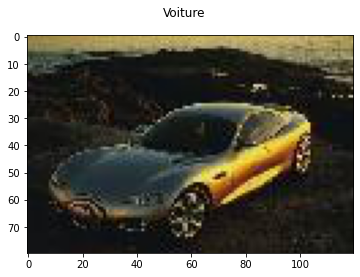

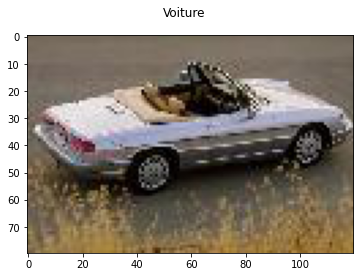

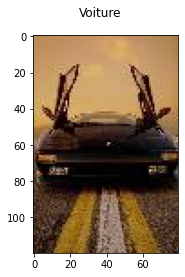

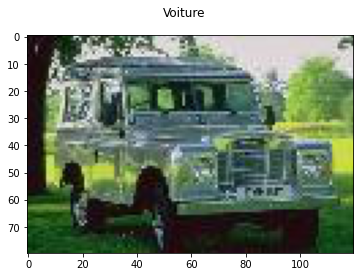

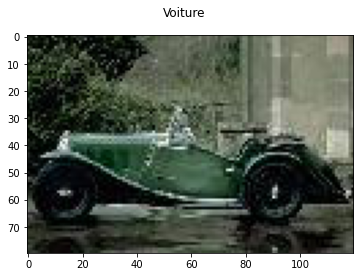

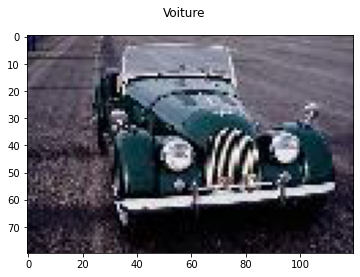

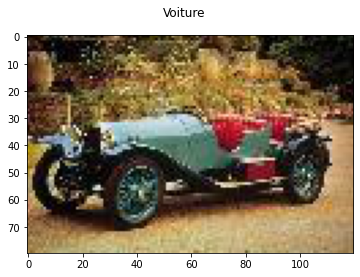

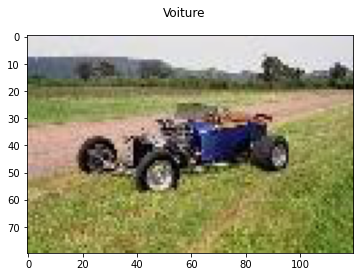

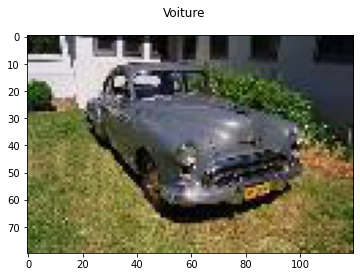

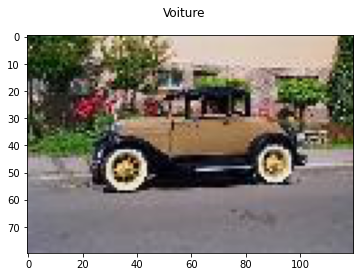

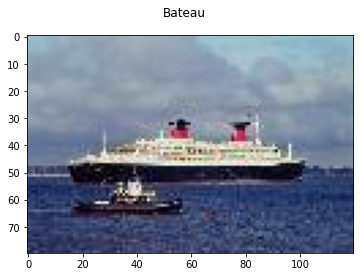

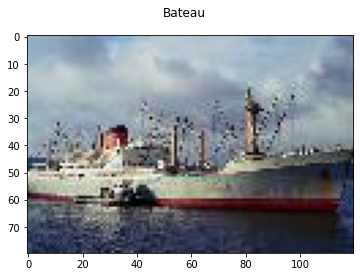

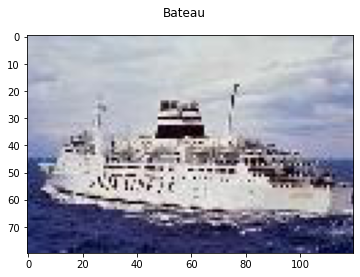

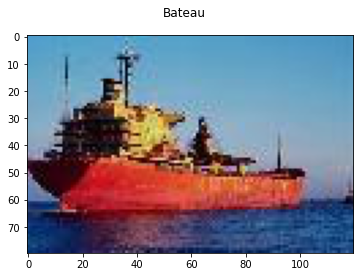

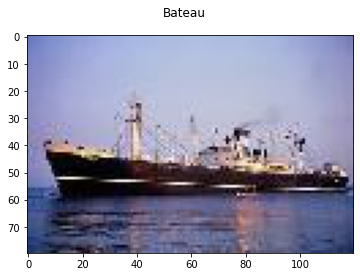

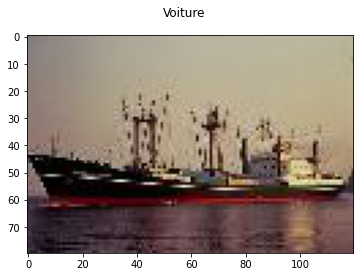

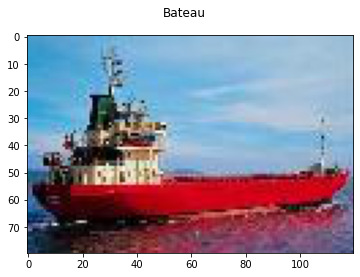

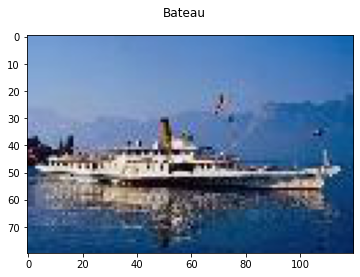

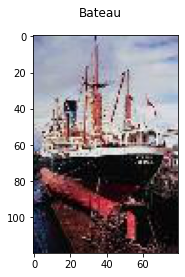

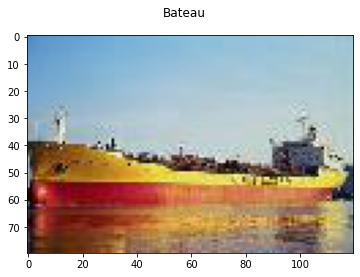

In [7]:
predict_svm = []

for i in range(len(loaded_images_test)):
    fig = plt.figure()
    predict_svm.append(modele_svm.predict([features.iloc[i]]))
    fig.suptitle(Etiq[int(predict_svm[i])])
    plt.imshow(loaded_images_test[i])

df1 = pd.DataFrame(data=img_tst_name)
predict_svm_New = []
for i in predict_svm:
    if i == 0:
        predict_svm_New.append('obj_car')
    else:
        predict_svm_New.append('obj_shape')
df2 = pd.DataFrame(data=predict_svm_New)
svm_rapport = pd.concat([df1,df2],axis=1)
svm_rapport.to_csv('prediction_Par_SVM_Abibou_MIDVI.csv',sep=',',header=['name','predict'],index=False)

In [8]:
from sklearn.tree import DecisionTreeClassifier

modele_arb = DecisionTreeClassifier()
modele_arb.fit(balanced_fe,balanced_tr)

DecisionTreeClassifier()

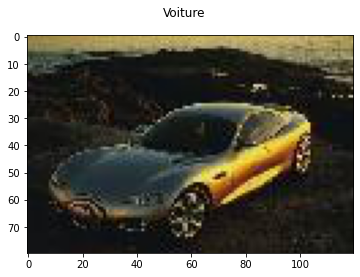

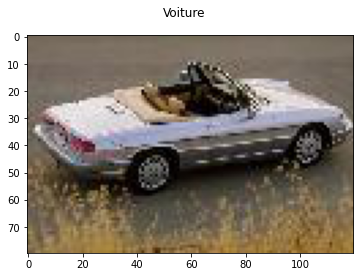

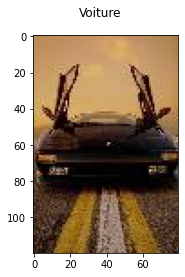

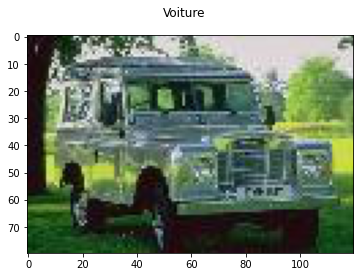

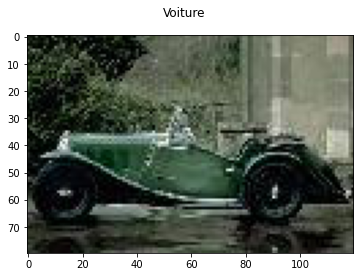

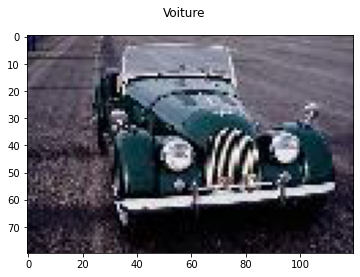

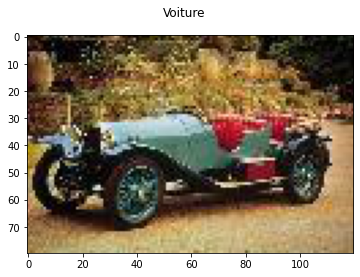

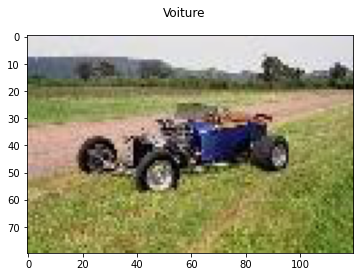

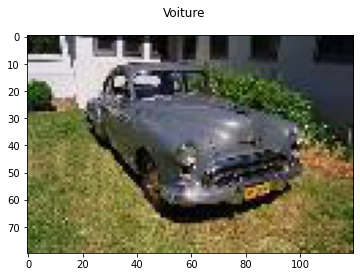

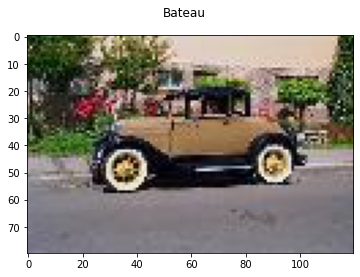

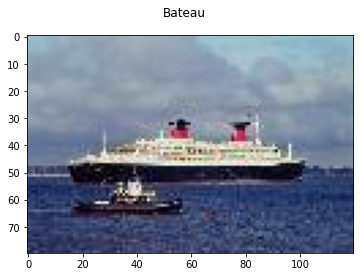

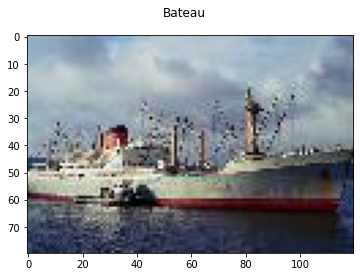

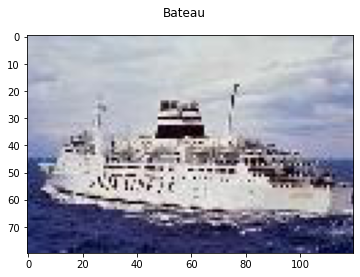

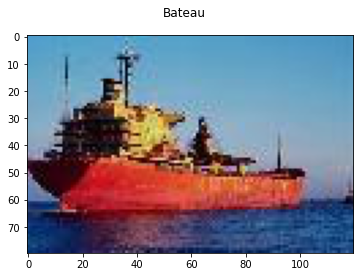

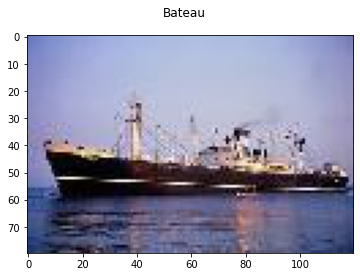

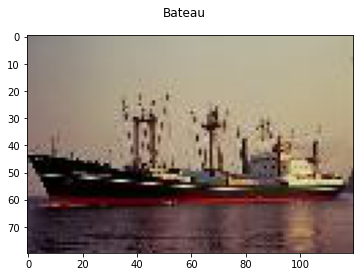

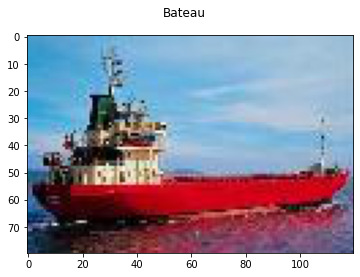

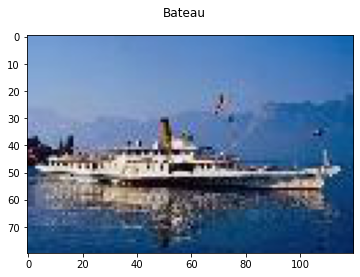

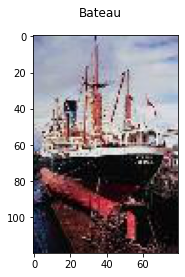

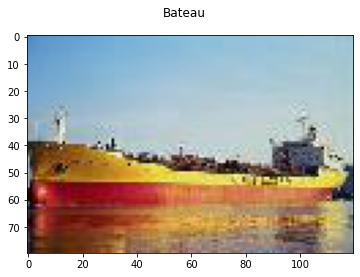

In [9]:
predict_arb=[]
for i in range(len(loaded_images_test)):
    fig = plt.figure()
    predict_arb.append(modele_arb.predict([features.iloc[i]]))
    fig.suptitle(Etiq[int(predict_arb[i])])
    plt.imshow(loaded_images_test[i])
predict_arb_New = []
for i in predict_svm:
    if i == 0:
        predict_arb_New.append('obj_car')
    else:
        predict_arb_New.append('obj_shape')
df2 = pd.DataFrame(data=predict_arb_New)
svm_rapport = pd.concat([df1,df2],axis=1)
svm_rapport.to_csv('prediction_Par_ARBRE_Abibou_MIDVI.csv',sep=',',header=['name','predict'],index=False)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
modele_knn = KNeighborsClassifier(n_neighbors=1)
modele_knn.fit(balanced_fe, balanced_tr)

KNeighborsClassifier(n_neighbors=1)

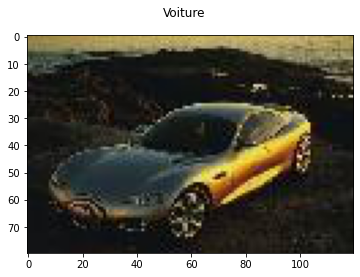

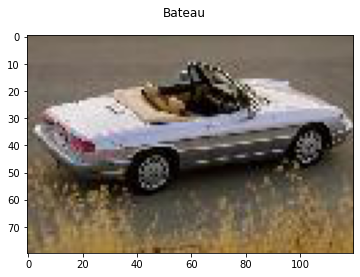

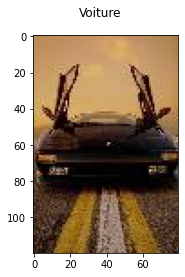

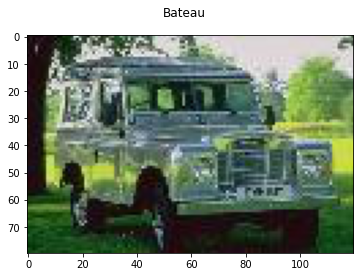

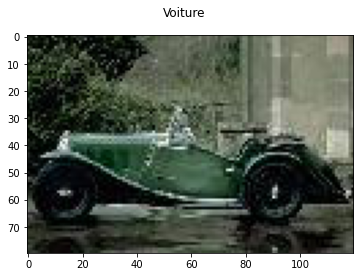

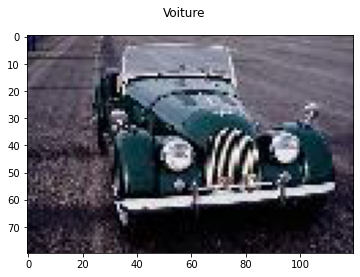

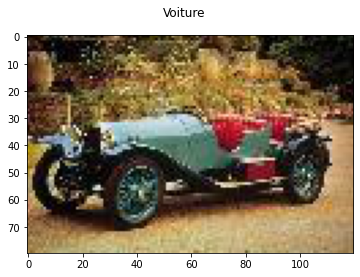

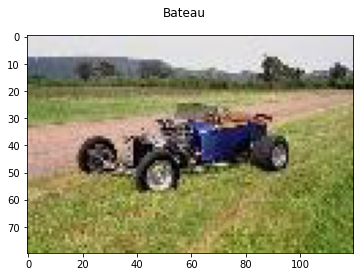

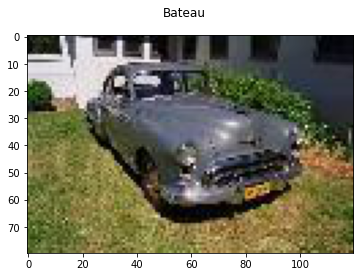

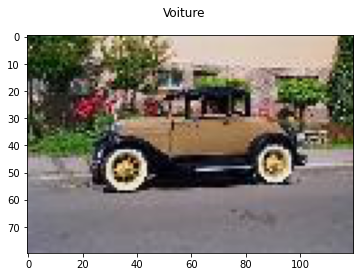

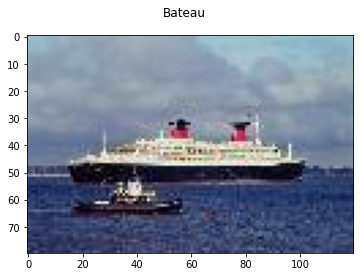

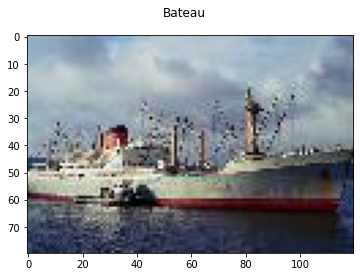

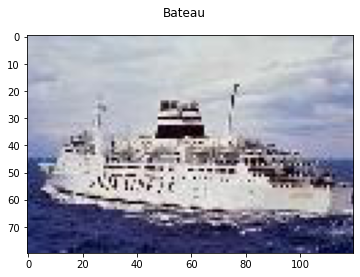

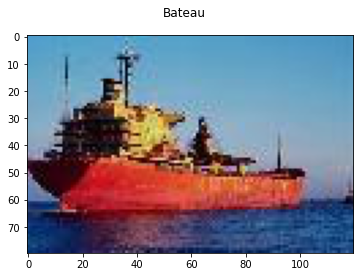

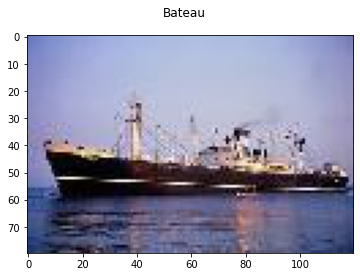

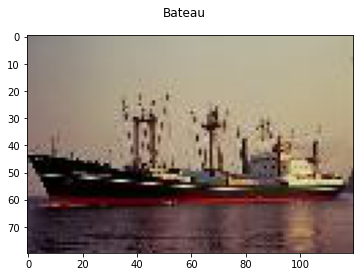

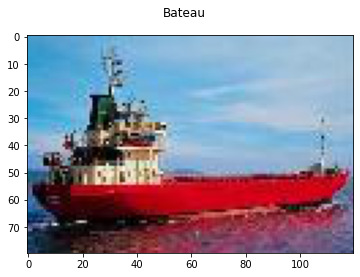

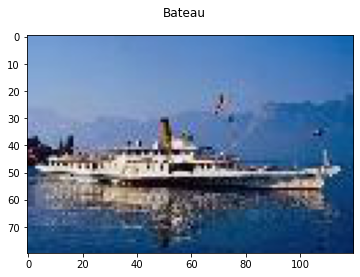

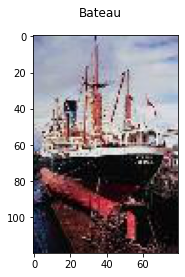

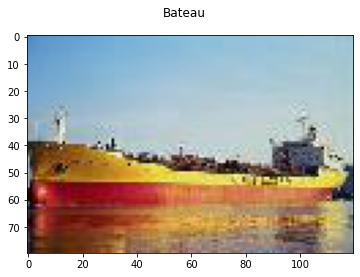

In [19]:
predict_knn=[]
for i in range(len(loaded_images_test)):
    fig = plt.figure()
    predict_knn.append(modele_knn.predict([features.iloc[i]]))
    fig.suptitle(Etiq[int(predict_knn[i])])
    plt.imshow(loaded_images_test[i])
    
predict_knn_New = []
for i in predict_svm:
    if i == 0:
        predict_knn_New.append('obj_car')
    else:
        predict_knn_New.append('obj_shape')
    
df2 = pd.DataFrame(data=predict_knn)
svm_rapport = pd.concat([df1,df2],axis=1)
svm_rapport.to_csv('prediction_Par_KNN_Abibou_MIDVI.csv',sep=',',header=['name','predict'],index=False)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
print("La matrice de confusion en utilisant le modèle SVM")
print(confusion_matrix(y_true, predict_svm))

print(classification_report(y_true, predict_svm))

La matrice de confusion en utilisant le modèle SVM
[[10  0]
 [ 1  9]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        10
           1       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [15]:
print("La matrice de confusion en utilisant le modèle Tree_Decision")
print(confusion_matrix(y_true, predict_arb))

print(classification_report(y_true, predict_arb))

La matrice de confusion en utilisant le modèle Tree_Decision
[[ 9  1]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



In [16]:
print("La matrice de confusion en utilisant le modèle KNN")
print(confusion_matrix(y_true, predict_knn))

print(classification_report(y_true, predict_knn))

La matrice de confusion en utilisant le modèle KNN
[[ 6  4]
 [ 0 10]]
              precision    recall  f1-score   support

           0       1.00      0.60      0.75        10
           1       0.71      1.00      0.83        10

    accuracy                           0.80        20
   macro avg       0.86      0.80      0.79        20
weighted avg       0.86      0.80      0.79        20

